In [1]:
!nvidia-smi

Wed Aug 14 10:21:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
# import

import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchinfo
import os
from pytz import timezone
from tqdm import tqdm


# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)  # 출력결과: cuda

if DEVICE.type == "cuda":
    print("Count of using GPUs:", torch.cuda.device_count())
    print("Current cuda device:", torch.cuda.current_device())
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")

    print("Memory Cached:", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Device: cuda
Count of using GPUs: 2
Current cuda device: 0
Memory Allocated: 0.1 GB
Memory Cached: 0.2 GB


In [13]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.0001
MOMENTUM = 0.9
BATCH_SIZE = 128
EPOCHS = 30
IMG_SIZE = 224
NUM_CLASSES = 10

In [14]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [15]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [16]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [17]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [18]:
def training_loop(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):
    train_losses = []
    valid_losses = []
    print(
        datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
        "--- Start Training Loop ---",
    )

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        running_loss = 0.0
        valid_loader_tqdm = tqdm(valid_loader, desc=f"Validation {epoch + 1}/{epochs}", leave=False)
        with torch.no_grad():
            for inputs, labels in valid_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
        
        valid_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch + 1}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )
        scheduler.step()

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [19]:
class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=False):
        super(BottleneckResidualBlock, self).__init__()
        o1, o2, o3 = out_channels
        self.conv1 = nn.Conv2d(
            in_channels, o1, kernel_size=1, stride=stride, bias=False
        )
        self.bn1 = nn.BatchNorm2d(o1)
        self.conv2 = nn.Conv2d(o1, o2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(o2)
        self.conv3 = nn.Conv2d(o2, o3, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(o3)

        if downsample:
            self.downsample = nn.Conv2d(in_channels, o3, kernel_size=1, stride=stride, bias=False)
            self.bn_downsample = nn.BatchNorm2d(o3)
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.downsample:
            identity = self.bn_downsample(self.downsample(identity))
        x = F.relu(x + identity)
        return x


class ResNet50Conv2_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv2_x, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2_a = BottleneckResidualBlock(
            64, [64, 64, 256], stride=1, downsample=True
        )
        self.conv2_b = BottleneckResidualBlock(256, [64, 64, 256], stride=1)
        self.conv2_c = BottleneckResidualBlock(256, [64, 64, 256], stride=1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv2_a(x)
        x = self.conv2_b(x)
        x = self.conv2_c(x)
        return x


class ResNet50Conv3_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv3_x, self).__init__()
        self.conv3_a = BottleneckResidualBlock(
            256, [128, 128, 512], stride=2, downsample=True
        )
        self.conv3_b = BottleneckResidualBlock(512, [128, 128, 512], stride=1)
        self.conv3_c = BottleneckResidualBlock(512, [128, 128, 512], stride=1)
        self.conv3_d = BottleneckResidualBlock(512, [128, 128, 512], stride=1)

    def forward(self, x):
        x = self.conv3_a(x)
        x = self.conv3_b(x)
        x = self.conv3_c(x)
        x = self.conv3_d(x)
        return x


class ResNet50Conv4_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv4_x, self).__init__()
        self.conv4_a = BottleneckResidualBlock(
            512, [256, 256, 1024], stride=2, downsample=True
        )
        self.conv4_b = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_c = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_d = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_e = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_f = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)

    def forward(self, x):
        x = self.conv4_a(x)
        x = self.conv4_b(x)
        x = self.conv4_c(x)
        x = self.conv4_d(x)
        x = self.conv4_e(x)
        x = self.conv4_f(x)
        return x


class ResNet50Conv5_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv5_x, self).__init__()
        self.conv5_a = BottleneckResidualBlock(
            1024, [512, 512, 2048], stride=2, downsample=True
        )
        self.conv5_b = BottleneckResidualBlock(2048, [512, 512, 2048], stride=1)
        self.conv5_c = BottleneckResidualBlock(2048, [512, 512, 2048], stride=1)

    def forward(self, x):
        x = self.conv5_a(x)
        x = self.conv5_b(x)
        x = self.conv5_c(x)
        return x


# ResNet50 모델 정의
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2_x = ResNet50Conv2_x()
        self.conv3_x = ResNet50Conv3_x()
        self.conv4_x = ResNet50Conv4_x()
        self.conv5_x = ResNet50Conv5_x()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, NUM_CLASSES)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


torchinfo.summary(
    ResNet50(),
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    row_settings=["depth", "var_names"],
)

# torchinfo.summary(
#     models.resnet50(pretrained=False),
#     input_size=(1, 3, IMG_SIZE, IMG_SIZE),
# )
# 1000개 클래스 분류에 대해서 학습 파라미터 수가 동일함을 확인

Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
ResNet50 (ResNet50)                                [1, 3, 224, 224]          [1, 10]                   --                        --
├─Conv2d (conv1): 1-1                              [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]
├─BatchNorm2d (bn1): 1-2                           [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --
├─ResNet50Conv2_x (conv2_x): 1-3                   [1, 64, 112, 112]         [1, 256, 56, 56]          --                        --
│    └─MaxPool2d (pool): 2-1                       [1, 64, 112, 112]         [1, 64, 56, 56]           --                        3
│    └─BottleneckResidualBlock (conv2_a): 2-2      [1, 64, 56, 56]           [1, 256, 56, 56]          --                        --
│    │    └─Conv2d (conv1): 3-1                    [1, 64, 56, 

Files already downloaded and verified


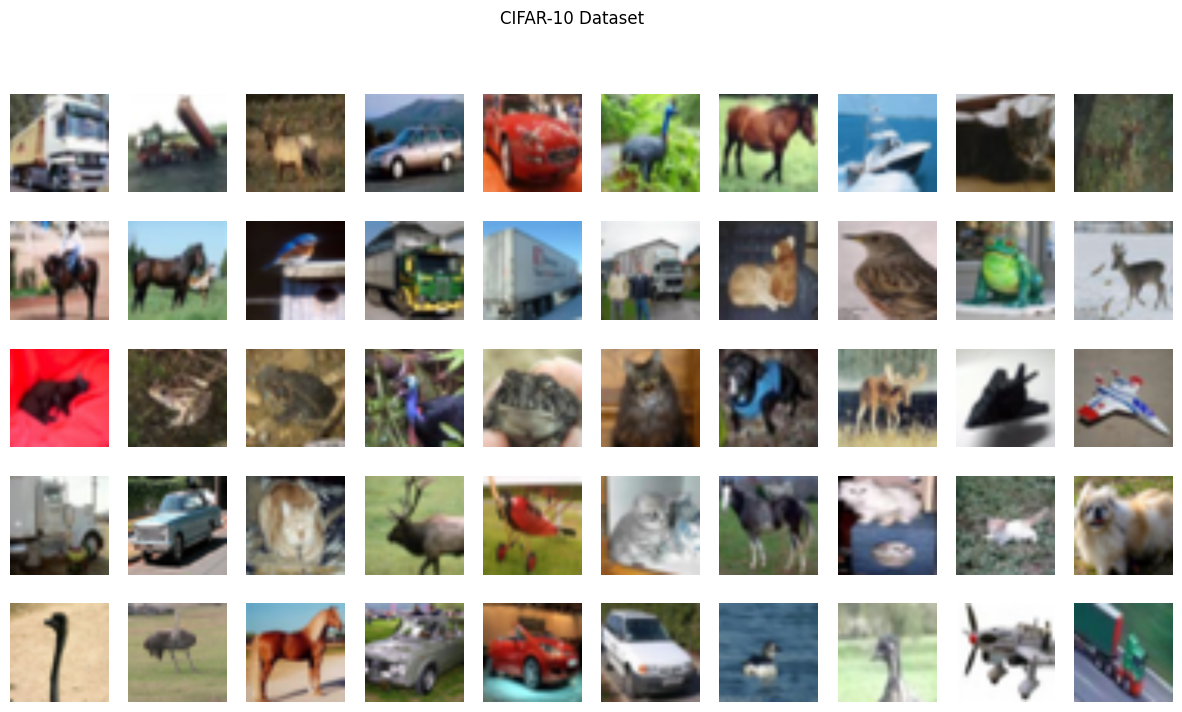

train dataset size:  40000
valid dataset size:  10000
test dataset size:  10000


In [20]:
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
        transforms.ToTensor(),
    ]
)

# 데이터셋 다운로드 및 생성
full_dataset = datasets.CIFAR10(root="cifar10_data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="cifar10_data", train=False, transform=transform)

test_size = len(test_dataset)
valid_size = test_size
train_size = len(full_dataset) - valid_size

train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 불러온 CIFAR-10 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(15, 8))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    img = train_dataset.dataset[index][0]
    img = img.permute(1, 2, 0)  # (채널, 높이, 너비) -> (높이, 너비, 채널)
    plt.imshow(img)

fig.suptitle("CIFAR-10 Dataset")
plt.show()

# 데이터셋 크기 출력
print("train dataset size: ", len(train_dataset))
print("valid dataset size: ", len(valid_dataset))
print("test dataset size: ", len(test_dataset))


19:22:16 --- Start Training Loop ---


19:27:10 ---  Epoch: 1	Train loss: 1.8539	Valid loss: 2.0271	Train accuracy: 42.54	Valid accuracy: 42.36


19:32:05 ---  Epoch: 2	Train loss: 1.2815	Valid loss: 1.4521	Train accuracy: 51.57	Valid accuracy: 50.28


19:36:59 ---  Epoch: 3	Train loss: 0.9745	Valid loss: 1.4256	Train accuracy: 52.86	Valid accuracy: 51.92


19:41:53 ---  Epoch: 4	Train loss: 0.7685	Valid loss: 0.9104	Train accuracy: 71.77	Valid accuracy: 69.47


19:46:47 ---  Epoch: 5	Train loss: 0.6320	Valid loss: 1.0128	Train accuracy: 70.70	Valid accuracy: 67.69


19:51:42 ---  Epoch: 6	Train loss: 0.5228	Valid loss: 0.6112	Train accuracy: 83.99	Valid accuracy: 78.52


19:56:36 ---  Epoch: 7	Train loss: 0.4509	Valid loss: 0.6485	Train accuracy: 84.56	Valid accuracy: 78.11


20:01:31 ---  Epoch: 8	Train loss: 0.3741	Valid loss: 0.7167	Train accuracy: 84.75	Valid accuracy: 78.53


20:06:26 ---  Epoch: 9	Train loss: 0.3403	Valid loss: 0.5531	Train accuracy: 90.27	Valid accuracy: 81.34


20:11:20 ---  Epoch: 10	Train loss: 0.2794	Valid loss: 0.6807	Train accuracy: 88.23	Valid accuracy: 79.17


20:16:15 ---  Epoch: 11	Train loss: 0.1313	Valid loss: 0.4094	Train accuracy: 97.75	Valid accuracy: 87.00


20:21:09 ---  Epoch: 12	Train loss: 0.0868	Valid loss: 0.4274	Train accuracy: 98.66	Valid accuracy: 87.54


20:26:03 ---  Epoch: 13	Train loss: 0.0632	Valid loss: 0.4536	Train accuracy: 99.20	Valid accuracy: 87.48


20:30:56 ---  Epoch: 14	Train loss: 0.0441	Valid loss: 0.4763	Train accuracy: 99.50	Valid accuracy: 87.46


20:35:50 ---  Epoch: 15	Train loss: 0.0319	Valid loss: 0.4937	Train accuracy: 99.61	Valid accuracy: 87.28


20:40:45 ---  Epoch: 16	Train loss: 0.0235	Valid loss: 0.5115	Train accuracy: 99.82	Valid accuracy: 87.20


20:45:40 ---  Epoch: 17	Train loss: 0.0182	Valid loss: 0.5235	Train accuracy: 99.90	Valid accuracy: 87.39


20:50:34 ---  Epoch: 18	Train loss: 0.0143	Valid loss: 0.5129	Train accuracy: 99.94	Valid accuracy: 87.61


20:55:29 ---  Epoch: 19	Train loss: 0.0120	Valid loss: 0.5259	Train accuracy: 99.96	Valid accuracy: 87.18


21:00:23 ---  Epoch: 20	Train loss: 0.0091	Valid loss: 0.5370	Train accuracy: 99.98	Valid accuracy: 87.55


21:05:18 ---  Epoch: 21	Train loss: 0.0066	Valid loss: 0.5381	Train accuracy: 99.99	Valid accuracy: 87.70


21:10:13 ---  Epoch: 22	Train loss: 0.0063	Valid loss: 0.5353	Train accuracy: 99.99	Valid accuracy: 87.69


21:15:07 ---  Epoch: 23	Train loss: 0.0057	Valid loss: 0.5207	Train accuracy: 100.00	Valid accuracy: 87.41


21:20:02 ---  Epoch: 24	Train loss: 0.0062	Valid loss: 0.5200	Train accuracy: 100.00	Valid accuracy: 87.32


21:24:56 ---  Epoch: 25	Train loss: 0.0055	Valid loss: 0.5207	Train accuracy: 99.99	Valid accuracy: 87.83


21:29:50 ---  Epoch: 26	Train loss: 0.0055	Valid loss: 0.5225	Train accuracy: 100.00	Valid accuracy: 87.66


21:34:44 ---  Epoch: 27	Train loss: 0.0053	Valid loss: 0.5180	Train accuracy: 99.99	Valid accuracy: 87.86


21:39:39 ---  Epoch: 28	Train loss: 0.0051	Valid loss: 0.5350	Train accuracy: 100.00	Valid accuracy: 87.51


21:44:33 ---  Epoch: 29	Train loss: 0.0044	Valid loss: 0.5232	Train accuracy: 100.00	Valid accuracy: 87.74


21:49:28 ---  Epoch: 30	Train loss: 0.0048	Valid loss: 0.5202	Train accuracy: 100.00	Valid accuracy: 87.67


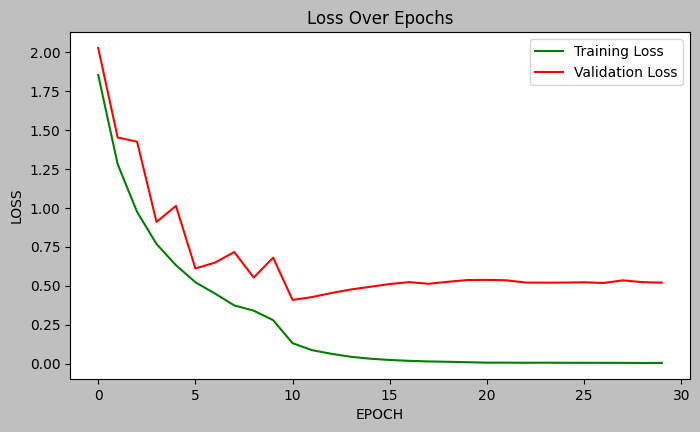

In [21]:
torch.manual_seed(RANDOM_SEED)

_model = ResNet50().cuda()
model = nn.DataParallel(_model).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, scheduler, train_loader, valid_loader, EPOCHS, DEVICE
)

Test Loss: 0.5886, Test Accuracy: 0.8668


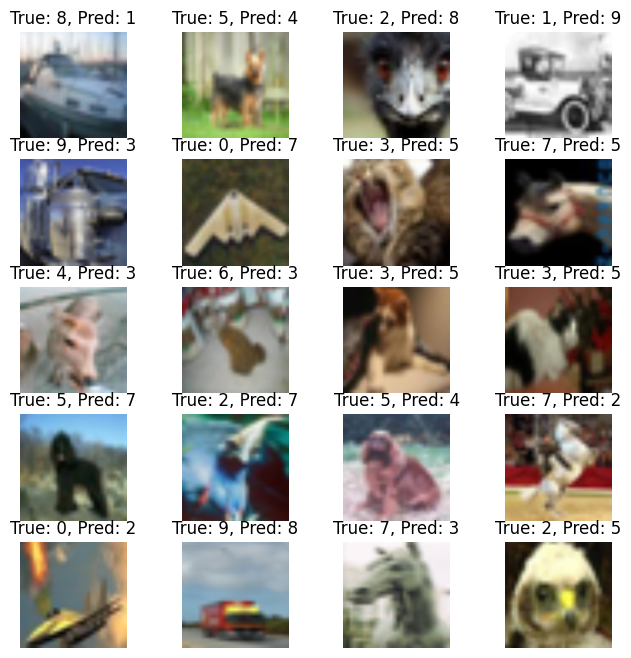

In [22]:
import matplotlib.pyplot as plt

# 테스트 데이터셋을 사용하여 모델의 성능을 평가하고 틀린 예시를 저장
def test_and_collect_mistakes(test_loader, model, criterion, device):
    model.eval()  # 평가 모드로 전환
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    mistakes = []

    with torch.no_grad():  # 평가시에는 그래디언트 계산 불필요
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 순전파와 손실 기록하기
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)

            # 예측 및 정확도 계산
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 틀린 예시 저장
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    mistakes.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))

    epoch_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total

    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return epoch_loss, accuracy, all_preds, all_labels, mistakes

# 모델 학습이 완료된 후 평가 수행
test_loss, test_accuracy, test_preds, test_labels, mistakes = test_and_collect_mistakes(test_loader, model, criterion, DEVICE)

# 틀린 예시 시각화
def plot_mistakes(mistakes, num_examples=20):
    plt.figure(figsize=(8, 8))
    for i, (image, true_label, pred_label) in enumerate(mistakes[:num_examples]):
        plt.subplot(5, 4, i + 1)
        plt.axis('off')
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.show()
    
# 틀린 예시 출력
plot_mistakes(mistakes)
